In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14035066675703881806
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3153041817
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10569967087886769971
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [1]:
import os
import keras

# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
x_train.shape[1:]

(3072,)

In [6]:
def build_mlp(input_shape,output_units=10,num_neurons=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i ,n_units in enumerate(num_neurons):
        if i==0:
            x = keras.layers.Dense(units=n_units , activation = "relu", name = "hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units , activation=  "relu", name = "hidden_layer"+str(i+1))(x)
    
    
    out = keras.layers.Dense(units=output_units  , activation="softmax",name = "output")(x)
    
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = [1e-1,1e-2,1e-3,1e-4,1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95

from keras.optimizers import SGD

In [8]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use

50000/50000 [==============================] - 3s 53us/step - loss: 2.3041 - acc: 0.0958 - val_loss: 2.3065 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 3s 54us/step - loss: 2.3044 - acc: 0.0985 - val_loss: 2.3036 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.3046 - acc: 0.0984 - val_loss: 2.3038 - val_acc: 0.1000
Experiment with LR = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)

Epoch 50/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.3681 - acc: 0.8688 - val_loss: 2.4106 - val_acc: 0.5063
Experiment with LR = 0.001000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
______________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/step - loss: 2.2354 - acc: 0.1845 - val_loss: 2.1647 - val_acc: 0.2353
Epoch 2/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.1189 - acc: 0.2539 - val_loss: 2.0770 - val_acc: 0.2744
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.0451 - acc: 0.2826 - val_loss: 2.0155 - val_acc: 0.3027
Epoch 4/50
50000/50000 [==============================] - 3s 54us/step - loss: 1.9895 - acc: 0.3059 - val_loss: 1.9678 - val_acc: 0.3195
Epoch 5/50
50000/50000 [==============================] - 3s 57us/step - loss: 1.9476 - acc: 0.3202 - val_loss: 1.9309 - val_acc: 0.3297
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 1.9147 - acc: 0.3341 - val_loss: 1.9028 - val_acc: 0.3366
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 1.8882 - acc: 0.3445 - val_loss: 1.8787 - val_acc

50000/50000 [==============================] - 3s 57us/step - loss: 2.2776 - acc: 0.1466 - val_loss: 2.2624 - val_acc: 0.1525
Epoch 3/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.2501 - acc: 0.1613 - val_loss: 2.2421 - val_acc: 0.1675
Epoch 4/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.2327 - acc: 0.1744 - val_loss: 2.2268 - val_acc: 0.1790
Epoch 5/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.2181 - acc: 0.1869 - val_loss: 2.2133 - val_acc: 0.1927
Epoch 6/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.2048 - acc: 0.1971 - val_loss: 2.2004 - val_acc: 0.2032
Epoch 7/50
50000/50000 [==============================] - 3s 52us/step - loss: 2.1918 - acc: 0.2060 - val_loss: 2.1877 - val_acc: 0.2117
Epoch 8/50
50000/50000 [==============================] - 3s 53us/step - loss: 2.1791 - acc: 0.2144 - val_loss: 2.1752 - val_acc: 0.2181
Epoch 9/50
50000/50000 [============================

In [27]:
results.keys()

dict_keys(['exp-lr-0.1', 'exp-lr-0.01', 'exp-lr-0.001', 'exp-lr-0.0001', 'exp-lr-1e-05'])

In [32]:
range(len(results[cond]['train-loss']))

range(0, 50)

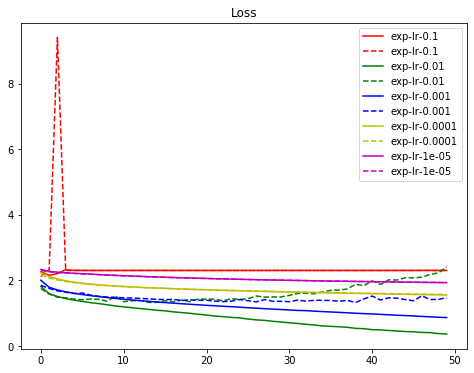

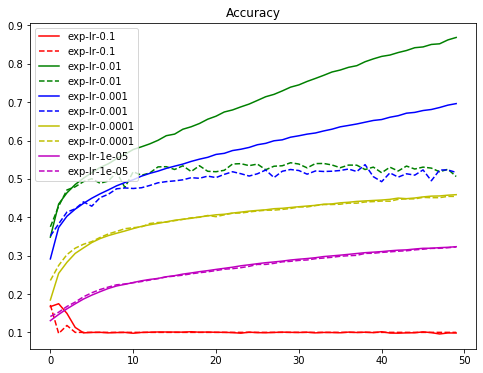

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()): ## range(0,50)
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()